In [1]:
import os

os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

In [2]:
!ls ./Data/Weather/

decon_WA_PRCP_s20.parquet  stations.parquet  WA.tgz
decon_WA_SNWD.parquet	   STAT_WA.pickle    Weather_Stations.tgz
recon_WA_SNWD.parquet	   WA.parquet


In [3]:
import ipyleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution coefficients on a map

## Loading libraries and information

### Load the required libraries

In [5]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [6]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [7]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

###  Load stations information

In [8]:
data_dir='./Data/Weather/'
!du -sh $data_dir/*

49M	./Data/Weather//STAT_WA.pickle
75M	./Data/Weather//WA.parquet
62M	./Data/Weather//WA.tgz
348K	./Data/Weather//Weather_Stations.tgz
13M	./Data/Weather//decon_WA_PRCP_s20.parquet
1.1M	./Data/Weather//decon_WA_SNWD.parquet
1.1M	./Data/Weather//recon_WA_SNWD.parquet
420K	./Data/Weather//stations.parquet


In [9]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet')
stations_df.show(3)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 3 rows



### Load the reconstructions DataFrame

For details about the columns in this DataFrame see the README notebook

In [12]:
### Read the data frame from a parquet file.

state='WA'
meas='PRCP_s20'

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(1)

15972
+-----------+-----------+--------------------+----+-------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+----------------+-------------------+--------+------------------+-------------------+------------------+------------------+------------------+-----------------+----------------+
|Measurement|    Station|              Values|Year|            coeff_1|          coeff_2|          coeff_3|          coeff_4|           coeff_5|        dist_coast|         elevation|        latitude|          longitude|    name|             res_1|              res_2|             res_3|             res_4|             res_5|         res_mean|       total_var|
+-----------+-----------+--------------------+----+-------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+----------------+-------------------+--------+------------------+-------------------+-------

## Compute the count and average of `coef_1` for each station.

In [13]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,Dist_coast,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)

df2=df1.groupby(['station','latitude','longitude','elevation','Dist_coast']).agg({"station": "count", feature: "mean"})
#df2=df1.groupby(['station']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(25)

SELECT station, latitude,longitude,elevation,Dist_coast,coeff_1 FROM weather


,station,latitude,longitude,elevation,Dist_coast,count(station),avg(coeff_1)
72,USC00450008,46.965801,-123.829201,3.000000,1.311030,123,693.871029
44,USC00450013,47.261398,-123.714699,132.600006,33.051102,78,1412.309347
269,USC00450094,46.799999,-122.316704,396.799988,42.074501,38,75.769236
246,USC00450158,47.466702,-123.883301,64.000000,34.400002,7,1122.070698
24,USC00450176,48.511902,-122.613602,6.100000,0.681926,121,-194.821184
62,USC00450184,46.133301,-117.133301,1089.099976,417.734009,68,-267.230219
168,USC00450217,45.809200,-121.281097,712.000000,174.214005,50,-70.451578
148,USC00450257,48.200600,-122.128098,30.500000,19.337700,87,52.894541
32,USC00450456,47.772202,-121.481903,234.699997,56.968399,44,1014.526280
54,USC00450482,45.771702,-122.528603,86.599998,86.735397,81,157.758653


In [14]:
# Find long/lat bounding box
max_long=pdf['longitude'].max()
min_long=pdf['longitude'].min()
max_lat=pdf['latitude'].max()
min_lat=pdf['latitude'].min()


In [15]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))


## Map
* Each circle is centered at a station.  
* The area of the circle corresponds to the number of years SNWD was recorded at the station.  
* The color fill of the circle corresponds to the value of `avg(coeff_1)` defined by color-bar.

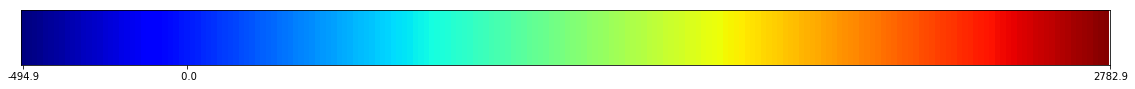

In [16]:
#def color_bar(_min,_max)
import pylab as plt
from matplotlib.pyplot import xticks,yticks
figure(figsize=[60,1])
ax = plt.subplot(111)
vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)
vals3.shape
ax.imshow(vals3);

midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());


In [23]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1200*np.sqrt(_count+0.0)), weight=1,
            color='#808080', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[47.29999923706055, -120.89039993286133], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Rectangle(bounds=[[45.599998474121094, -124.7332992553711], [49.0, -117.04750061035156]], fill_opacity=0.0, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'no_clip', 'opacity', 'pointer_events', 'smooth_factor', 'stroke', 'weight']), Circle(color='#808080', fill_color='#09f0ee', fill_opacity=0.4, location=[46.96580123901367, -123.8292007446289], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=13308, weight=1), Circle(color='#808080', fill_color='#beff39', fill_opacity=0.4, location=[47.26139831542969, -123.7146987915039], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=10598, weight=1), Circle(color='#808080', fill_color='#0030ff', fill_opacity=0.4, location=[46.79999923706055, -122.31670379638672], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=7397, weight=1), Circle(color='#808080', fill_color='#77ff80', fill_opacity=0.4, location=[47.46670150756836, -123.88330078125], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=3174, weight=1), Circle(color='#808080', fill_color='#0000e8', fill_opacity=0.4, location=[48.51190185546875, -122.61360168457031], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=13200, weight=1), Circle(color='#808080', fill_color='#0000cd', fill_opacity=0.4, location=[46.13330078125, -117.13330078125], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=9895, weight=1), Circle(color='#808080', fill_color='#0004ff', fill_opacity=0.4, location=[45.809200286865234, -121.28109741210938], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=8485, weight=1), Circle(color='#808080', fill_color='#0028ff', fill_opacity=0.4, location=[48.200599670410156, -122.12809753417969], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=11192, weight=1), Circle(color='#808080', fill_color='#5aff9d', fill_opacity=0.4, location=[47.77220153808594, -121.48190307617188], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=7959, weight=1), Circle(color='#808080', fill_color='#0048ff', fill_opacity=0.4, location=[45.77170181274414, -122.52860260009766], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=1

### Something to try
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

### Is coef_1 related to elevation ?

(-100, 1000)

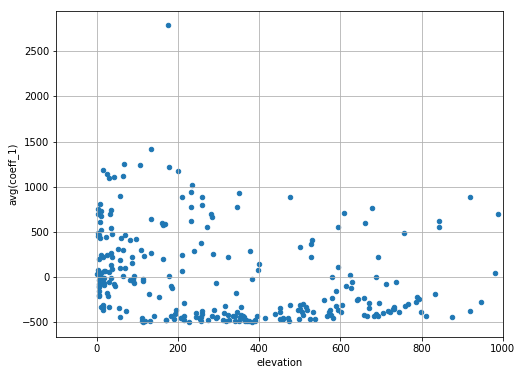

In [21]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)',figsize=(8,6));
grid()
xlim([-100,1000])

## Summary
* We saw how to use `ipyLeaflet` to present data on top of maps.
* We saw that in NY state, most of the snow accumulation is in the Adirondacks.
* Snow accumulation increases with elevation, but the relationship is weak: locations with elevation 400-600 meters have widely varying accumulations of snow.

## See you next time